In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('paper_style.mplstyle')
import mtbvartools as vt
from mtbvartools.vcf import filterDataFrame
from tqdm import tqdm

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

## WhiB6 variant - esxBA expression swarm plot

In [2]:
# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)
# get relative expression by strain
mean_exp = exp_df.T.groupby('strain').mean().mean()
rel_exp = exp_df - mean_exp.values.reshape(-1, 1)
rel_exp_by_strain = rel_exp.T.groupby('strain').mean()

# load variants
variant_vcb_path = 'datasets/variants/rnaseq/241103_variant_calls.vcb'
variant_vcb = vt.CallBytestream(
    variant_vcb_path)

# load lineage data
lineage_data_path = f'datasets/lineage_assignments.csv'
lineage_df = pd.read_csv(
    lineage_data_path,
    index_col=0).astype('str')  # enforce string

# load variant annotations and filter
annotations_path = 'datasets/variants/rnaseq/241103_event_calls.vcb/event_calls.annotated.csv'
annotations_df = pd.read_csv(
    annotations_path, index_col=['pos', 'ref', 'alt'])

# filter to get likely deleterious variants
deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'transcript_ablation',
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05}
deleterious_df = filterDataFrame(
    annotations_df, function_dict=deleterious_settings)

In [3]:
strain_names = np.asarray(variant_vcb.calls.col)

cds_var_strains = strain_names[np.any(
    variant_vcb.calls.loc[list(deleterious_df.loc[deleterious_df.Gene_ID == 'Rv3862c'].index.values)] == 1, axis=0)]

upstream_var_strains = strain_names[np.any([
    variant_vcb.calls.loc[(4338595, 'GC', 'G')] == 0,
    variant_vcb.calls.loc[(4338593, 'G', 'A')] == 1,
    variant_vcb.calls.loc[(4338594, 'A', 'C')] == 1,
    variant_vcb.calls.loc[(4338596, 'CT', 'C')] == 1], axis=0)]

L1_var_strains = lineage_df.loc[lineage_df.loc[:, 'lineage'] == '1'].index

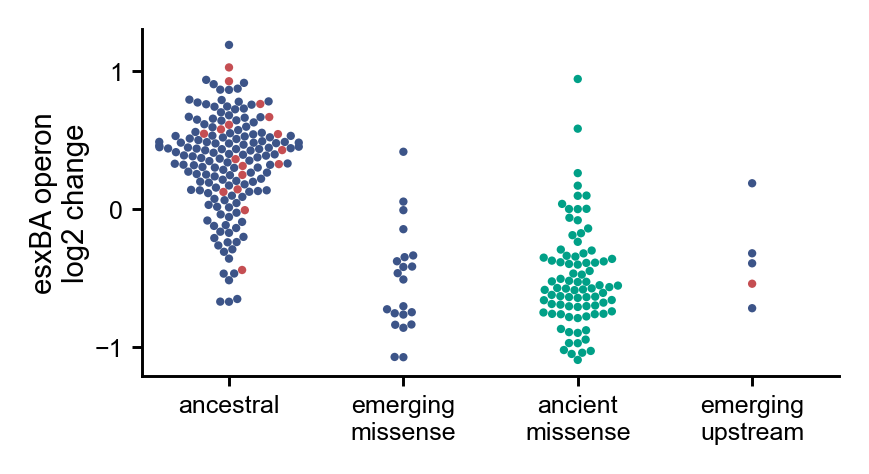

In [4]:
output_dir = 'outputs/figures'
output_name = '5B_whiB6_scatter.pdf'

# mean expression of these strains
plot_df = pd.DataFrame(
    rel_exp_by_strain.loc[:, ['Rv3872', 'Rv3873', 'Rv3874', 'Rv3875']].mean(1))

plot_df.columns = ['value']
plot_df.loc[:, 'category'] = 'ancestral'
plot_df.loc[cds_var_strains, 'category'] = 'emerging\nmissense'
plot_df.loc[upstream_var_strains, 'category'] = 'emerging\nupstream'
plot_df.loc[L1_var_strains, 'category'] = 'ancient\nmissense'

# linage list
plot_df.loc[:, 'lineage'] = lineage_df.loc[plot_df.index]

fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

swarm_order = ['ancestral', 'emerging\nmissense', 'ancient\nmissense', 'emerging\nupstream']

# make a swarmplot
sns.swarmplot(
    ax=ax,
    data=plot_df,
    hue='lineage',
    palette={
        '1': colors['dgreen'],
        '2': colors['dblue'],
        '4': colors['dred']},
    x='category',
    y='value',
    color='silver',
    s=2,
    order=swarm_order,
    legend=False)

ax.set_xlabel('')
ax.set_ylabel('esxBA operon\nlog2 change')
ax.set_yticks([-1, 0, 1])
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

## Cumulative WhiB6 variants

In [2]:
annotated_calls = 'datasets/variants/global/241104_event_calls.vcb/event_calls.annotated.csv'

# filter to get likely deleterious variants
deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05}
deleterious_calls = filterDataFrame(
    pd.read_csv(annotated_calls, index_col=['pos', 'ref', 'alt']), function_dict=deleterious_settings)
target_calls = deleterious_calls.loc[deleterious_calls.loc[:, 'Gene_ID'] == 'Rv3862c']

In [3]:
event_vcb_path = 'datasets/variants/global/241104_event_calls.vcb'
open_events = vt.CallBytestream(
    event_vcb_path, False, True)
variant_vcb_path = 'datasets/variants/global/241104_variant_calls.vcb'
open_variants = vt.CallBytestream(
    variant_vcb_path, False, True)

tree = vt.loadTree(
    'datasets/variants/global/241104_ancestor_calls.vcb/tree.nwk')

event_variants_index = pd.MultiIndex.from_tuples(
    open_events.nodes.col, names=['pos', 'ref', 'alt'])
variant_calls_index = pd.MultiIndex.from_tuples(
    open_variants.nodes.col, names=['pos', 'ref', 'alt'])

event_calls_mask = event_variants_index.isin(target_calls.index)
variant_calls_mask = variant_calls_index.isin(target_calls.index)

### Lineage 1

In [4]:
root_node = 'internal4119'
output_dict = {}
cumulative_explained = []
for node in tqdm(list(tree.find_node_with_label(root_node).preorder_iter())):
    # check for nodes called as alt
    found_variants = event_variants_index[np.where(np.all([
        open_events.nodes.loc[node.label] == 1,
        event_calls_mask], axis=0))[0]]
    if len(found_variants) > 0:
        # get leaves of the node
        leaves = [ln.label for ln in node.leaf_nodes()]
        # for each leaf, check that it is ALT at one of the found variants
        explained_leaves = []
        for leaf in leaves:
            if np.any(found_variants.isin(
                    variant_calls_index[open_variants.nodes.loc[leaf] == 1])):
                explained_leaves.append(leaf)
        # remove leaves that already have been explained by a parent node
        newly_explained_leaves = np.setdiff1d(explained_leaves, cumulative_explained)
        cumulative_explained += list(newly_explained_leaves)
        output_dict[node.label] = {'new':len(newly_explained_leaves), 'all':len(explained_leaves), 'tip_dist':node.distance_from_tip() + node.edge_length / 2}


# get total fraction of strains with target variant calls
leaf_labels = [ln.label for ln in tree.find_node_with_label(root_node).leaf_nodes()]
is_variant = 0
for leaf in leaf_labels:
    if np.any(open_variants.nodes.loc[leaf][variant_calls_mask] == 1):
        is_variant += 1
print(is_variant / len(leaf_labels), is_variant, len(leaf_labels))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 8239/8239 [01:14<00:00, 110.24it/s]


0.670873786407767 2764 4120


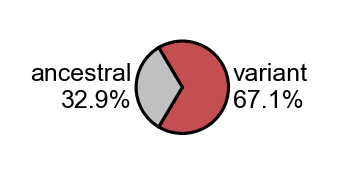

In [5]:
output_dir = 'outputs/figures'
output_name = '5FG_L1_whiB6_pie.pdf'

fraction_variant = is_variant / len(leaf_labels)
fraction_not_variant = 1 - fraction_variant

fig, ax = plt.subplots(1, 1, figsize=(0.5, 0.5))
ax.pie(
    [fraction_variant, fraction_not_variant],
    labels=[f'variant\n{fraction_variant*100:.1f}%', f'ancestral\n{fraction_not_variant*100:.1f}%'],
    colors=[colors['dred'], colors['gray']],
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.75},
    startangle=-fraction_variant*360/2,)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

32


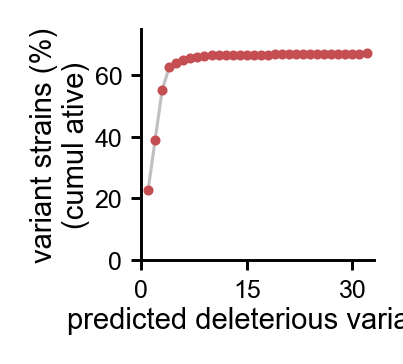

In [6]:
output_dir = 'outputs/figures'
output_name = '5FG_L1_cumulative_whiB6.pdf'

# convert to dataframe
plot_df = pd.DataFrame(
    output_dict).T
# remove nodes that did not add any new variants
plot_df = plot_df.loc[plot_df.loc[:, 'new'] != 0]
# sort in order of number of new variants
plot_df = plot_df.sort_values('new', ascending=False)
plot_df.loc[:, 'cumsum'] = plot_df.loc[:, 'new'].cumsum()
plot_df.loc[:, 'cumfraction'] = plot_df.loc[:, 'cumsum'] / len(tree.find_node_with_label(root_node).leaf_nodes()) * 100

print(len(plot_df))

# prepare plot
fig, ax = plt.subplots(1, 1, figsize=(1, 1))

ax.scatter(
    np.arange(len(plot_df)) + 1,
    plot_df.loc[:, 'cumfraction'],
    marker='o',
    color=colors['dred'],
    s=2, zorder=2)

ax.plot(
    np.arange(len(plot_df)) + 1,
    plot_df.loc[:, 'cumfraction'],
    lw=0.75,
    color=colors['gray'],
    zorder=0)

ax.set_ylim(0, 75)
ax.set_xlim(0, len(plot_df)+1)
ax.set_xticks([0, 15, 30])

ax.set_ylabel('variant strains (%)\n(cumul ative)')
ax.set_xlabel('predicted deleterious variants')
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

### Lineage 2

In [14]:
root_node = 'internal26428'
output_dict = {}
cumulative_explained = []
for node in tqdm(list(tree.find_node_with_label(root_node).preorder_iter())):
    # check for nodes called as alt
    found_variants = event_variants_index[np.where(np.all([
        open_events.nodes.loc[node.label] == 1,
        event_calls_mask], axis=0))[0]]
    if len(found_variants) > 0:
        # get leaves of the node
        leaves = [ln.label for ln in node.leaf_nodes()]
        # for each leaf, check that it is ALT at one of the found variants
        explained_leaves = []
        for leaf in leaves:
            if np.any(found_variants.isin(
                    variant_calls_index[open_variants.nodes.loc[leaf] == 1])):
                explained_leaves.append(leaf)
        # remove leaves that already have been explained by a parent node
        newly_explained_leaves = np.setdiff1d(explained_leaves, cumulative_explained)
        cumulative_explained += list(newly_explained_leaves)
        output_dict[node.label] = {'new':len(newly_explained_leaves), 'all':len(explained_leaves), 'tip_dist':node.distance_from_tip() + node.edge_length / 2}


# get total fraction of strains with target variant calls
leaf_labels = [ln.label for ln in tree.find_node_with_label(root_node).leaf_nodes()]
is_variant = 0
for leaf in leaf_labels:
    if np.any(open_variants.nodes.loc[leaf][variant_calls_mask] == 1):
        is_variant += 1
print(is_variant / len(leaf_labels), is_variant, len(leaf_labels))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32528/32528 [01:04<00:00, 503.75it/s]


0.06969883220651506 1134 16270


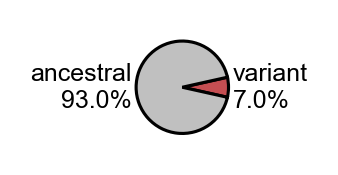

In [15]:
output_dir = 'outputs/figures'
output_name = '5FG_L2_whiB6_pie.pdf'

fraction_variant = is_variant / len(leaf_labels)
fraction_not_variant = 1 - fraction_variant

fig, ax = plt.subplots(1, 1, figsize=(0.5, 0.5))
ax.pie(
    [fraction_variant, fraction_not_variant],
    labels=[f'variant\n{fraction_variant*100:.1f}%', f'ancestral\n{fraction_not_variant*100:.1f}%'],
    colors=[colors['dred'], colors['gray']],
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.75},
    startangle=-fraction_variant*360/2,)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

341


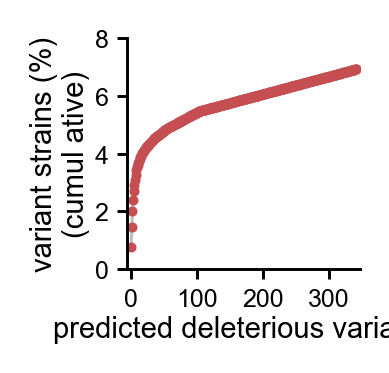

In [16]:
output_dir = 'outputs/figures'
output_name = '5FG_L2_cumulative_whiB6.pdf'

# convert to dataframe
plot_df = pd.DataFrame(
    output_dict).T
# remove nodes that did not add any new variants
plot_df = plot_df.loc[plot_df.loc[:, 'new'] != 0]
# sort in order of number of new variants
plot_df = plot_df.sort_values('new', ascending=False)
plot_df.loc[:, 'cumsum'] = plot_df.loc[:, 'new'].cumsum()
plot_df.loc[:, 'cumfraction'] = plot_df.loc[:, 'cumsum'] / len(tree.find_node_with_label(root_node).leaf_nodes()) * 100

print(len(plot_df))

# prepare plot
fig, ax = plt.subplots(1, 1, figsize=(1, 1))

ax.scatter(
    np.arange(len(plot_df)) + 1,
    plot_df.loc[:, 'cumfraction'],
    marker='o',
    color=colors['dred'],
    s=2, zorder=2)

ax.plot(
    np.arange(len(plot_df)) + 1,
    plot_df.loc[:, 'cumfraction'],
    lw=0.75,
    color=colors['gray'],
    zorder=0)

ax.set_ylim(0, 8)
ax.set_xlim(-5, len(plot_df) + 5)
ax.set_xticks([0, 100, 200, 300])

ax.set_ylabel('variant strains (%)\n(cumul ative)')
ax.set_xlabel('predicted deleterious variants')
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

### Lineage 4

In [17]:
root_node = 'internal55169'
output_dict = {}
cumulative_explained = []
for node in tqdm(list(tree.find_node_with_label(root_node).preorder_iter())):
    # check for nodes called as alt
    found_variants = event_variants_index[np.where(np.all([
        open_events.nodes.loc[node.label] == 1,
        event_calls_mask], axis=0))[0]]
    if len(found_variants) > 0:
        # get leaves of the node
        leaves = [ln.label for ln in node.leaf_nodes()]
        # for each leaf, check that it is ALT at one of the found variants
        explained_leaves = []
        for leaf in leaves:
            if np.any(found_variants.isin(
                    variant_calls_index[open_variants.nodes.loc[leaf] == 1])):
                explained_leaves.append(leaf)
        # remove leaves that already have been explained by a parent node
        newly_explained_leaves = np.setdiff1d(explained_leaves, cumulative_explained)
        cumulative_explained += list(newly_explained_leaves)
        output_dict[node.label] = {'new':len(newly_explained_leaves), 'all':len(explained_leaves), 'tip_dist':node.distance_from_tip() + node.edge_length / 2}


# get total fraction of strains with target variant calls
leaf_labels = [ln.label for ln in tree.find_node_with_label(root_node).leaf_nodes()]
is_variant = 0
for leaf in leaf_labels:
    if np.any(open_variants.nodes.loc[leaf][variant_calls_mask] == 1):
        is_variant += 1
print(is_variant / len(leaf_labels), is_variant, len(leaf_labels))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 57557/57557 [01:23<00:00, 691.72it/s]


0.02453412915987091 707 28817


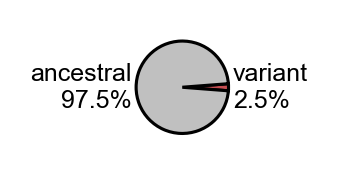

In [18]:
output_dir = 'outputs/figures'
output_name = '5FG_L4_whiB6_pie.pdf'

fraction_variant = is_variant / len(leaf_labels)
fraction_not_variant = 1 - fraction_variant

fig, ax = plt.subplots(1, 1, figsize=(0.5, 0.5))
ax.pie(
    [fraction_variant, fraction_not_variant],
    labels=[f'variant\n{fraction_variant*100:.1f}%', f'ancestral\n{fraction_not_variant*100:.1f}%'],
    colors=[colors['dred'], colors['gray']],
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.75},
    startangle=-fraction_variant*360/2,)

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

364


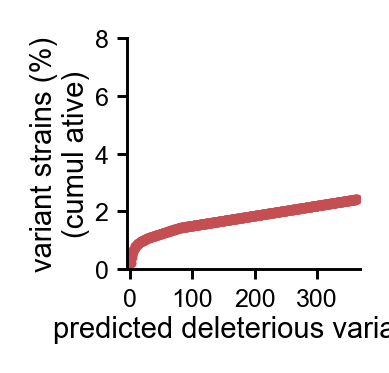

In [19]:
output_dir = 'outputs/figures'
output_name = '5FG_L4_cumulative_whiB6.pdf'

# convert to dataframe
plot_df = pd.DataFrame(
    output_dict).T
# remove nodes that did not add any new variants
plot_df = plot_df.loc[plot_df.loc[:, 'new'] != 0]
# sort in order of number of new variants
plot_df = plot_df.sort_values('new', ascending=False)
plot_df.loc[:, 'cumsum'] = plot_df.loc[:, 'new'].cumsum()
plot_df.loc[:, 'cumfraction'] = plot_df.loc[:, 'cumsum'] / len(tree.find_node_with_label(root_node).leaf_nodes()) * 100

print(len(plot_df))

# prepare plot
fig, ax = plt.subplots(1, 1, figsize=(1, 1))

ax.scatter(
    np.arange(len(plot_df)) + 1,
    plot_df.loc[:, 'cumfraction'],
    marker='o',
    color=colors['dred'],
    s=2, zorder=2)

ax.plot(
    np.arange(len(plot_df)) + 1,
    plot_df.loc[:, 'cumfraction'],
    lw=0.75,
    color=colors['gray'],
    zorder=0)

ax.set_ylim(0, 8)
ax.set_xlim(-5, len(plot_df) + 5)
ax.set_xticks([0, 100, 200, 300])

ax.set_ylabel('variant strains (%)\n(cumul ative)')
ax.set_xlabel('predicted deleterious variants')
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)